<a href="https://colab.research.google.com/github/pablo-arantes/ParametrizANI/blob/main/TorchANI_2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ParametrizANI - Dihedral Parametrization in the Cloud with TorchANI**

This is a Jupyter notebook to set up a protocol to calculate a reference map for two dihedrals angles with TorchANI , a PyTorch-based program for training/inference of ANI (ANAKIN-ME) deep learning models to obtain potential energy surfaces and other physical properties of molecular systems.  TorchANI is open-source and freely available on GitHub: https://github.com/aiqm/torchani.

---

 **This notebook is NOT a standard protocol for parametrization!** It is just simple parametrization pipeline illustrating each step of a protocol.

---
**Bugs**
- If you encounter any bugs, please report the issue to https://github.com/pablo-arantes/ParametrizANI/issues

**Acknowledgments**
- We would like to thank the OpenMM team for developing an excellent and open source engine.

- We would like to thank the [Roitberg](https://roitberg.chem.ufl.edu/) team for developing the fantastic [TorchANI](https://github.com/aiqm/torchani).

- We would like to thank the [Xavier Barril](http://www.ub.edu/bl/) team for their protocol on dihedrals parametrization and for the genetic algorithm script.

- We would like to thank [iwatobipen](https://twitter.com/iwatobipen) for his fantastic [blog](https://iwatobipen.wordpress.com/) on chemoinformatics.

- Also, credit to [David Koes](https://github.com/dkoes) for his awesome [py3Dmol](https://3dmol.csb.pitt.edu/) plugin.


- Finally, we would like to thank [Making it rain](https://github.com/pablo-arantes/making-it-rain) team, **Pablo R. Arantes** ([@pablitoarantes](https://twitter.com/pablitoarantes)), **Marcelo D. Polêto** ([@mdpoleto](https://twitter.com/mdpoleto)), **Conrado Pedebos** ([@ConradoPedebos](https://twitter.com/ConradoPedebos)) and **Rodrigo Ligabue-Braun** ([@ligabue_braun](https://twitter.com/ligabue_braun)), for their amazing work.

- For related notebooks see: https://github.com/pablo-arantes/ParametrizANI

# **Overview:**

**1.** Create the conformers for each dihedrals angles.

**2.** Calculate reference 2D map for two dihedrals angles with TorchANI.


# **Setting the environment for the calculation**

Firstly, we need to install all necessary libraries and packages for our protocol. The main packages we will be installing are:

1.    Anaconda (https://docs.conda.io/en/latest/miniconda.html)
2.    OpenMM (https://openmm.org/)
3.    RDKit (https://www.rdkit.org/)
4.    py3Dmol (https://pypi.org/project/py3Dmol/)
5.    Numpy (https://numpy.org/)
6.    Matplotlib (https://matplotlib.org/)
7.    TorchANI (https://aiqm.github.io/torchani/)

In [ ]:
#@title **Install Conda Colab**
#@markdown It will restart the kernel (session), don't worry.
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:16
🔁 Restarting kernel...


In [ ]:
#@title **Install dependencies**
#@markdown It will take a few minutes, please, drink a coffee and wait. ;-)
# install dependencies
import subprocess
import sys
subprocess.run("rm -rf /usr/local/conda-meta/pinned", shell=True)
subprocess.run("pip -q install py3Dmol", shell=True)
subprocess.run("mamba install pytorch torchvision -c pytorch", shell=True)
subprocess.run("pip install torchani", shell=True)
subprocess.run("pip install ase", shell=True)
subprocess.run("mamba install openmm=7.7.0", shell=True)
subprocess.run("mamba install openmmforcefields -c conda-forge -y", shell=True)
subprocess.run("mamba install -c conda-forge openbabel -y", shell=True)

In [ ]:
#@title **If you are running offline, please, run this cell to import PyTorch and TorchANI libraries**:

#@markdown This step is mandatory for offline calculations!

import torchani
import torch

Smiles: CNC(=O)[C@H](C)NC(C)=O


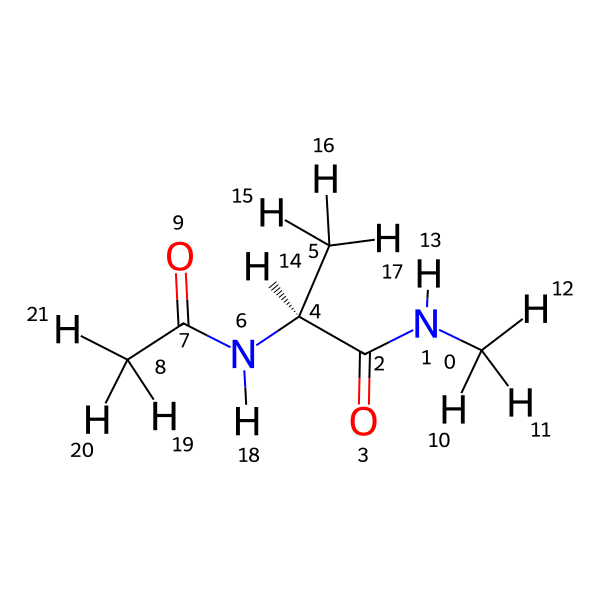

In [ ]:
#@title **Please, provide the necessary information for the molecule**:

#@markdown Type the smiles or filename (PDB and MOL formats) of your molecule. **Ex: C=CC(=O)OC, molecule.pdb or molecule.mol**

#@markdown Just remind you that if you want to use pdb or mol file, you should first upload the file here in Colab.

#@markdown If you don't know the exactly smiles, please, check at https://pubchem.ncbi.nlm.nih.gov/
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdMolTransforms
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdDepictor
from IPython.display import SVG
import ipywidgets as widgets
import rdkit
from rdkit.Chem.Draw import IPythonConsole
AllChem.SetPreferCoordGen(True)
from IPython.display import Image
from openbabel import pybel
import os

def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol

import py3Dmol


Type = "smiles" #@param ["smiles", "pdb", "mol"]

smiles_or_filename = 'CNC(=O)[C@H](C)NC(C)=O' #@param {type:"string"}

workDir = '/content/' #@param {type:"string"}

if Type == "smiles":
  Smiles = smiles_or_filename
  smiles_fig = Chem.MolFromSmiles(Smiles)
  hmol = Chem.AddHs(smiles_fig)
elif Type == "pdb":
  mol= [m for m in pybel.readfile(filename=smiles_or_filename, format='pdb')][0]
  out=pybel.Outputfile(filename=os.path.join(workDir,'mol.mol'),format='mol',overwrite=True)
  out.write(mol)
  out.close()
  mol = Chem.MolFromMolFile(os.path.join(workDir,'mol.mol'))
  Smiles = Chem.MolToSmiles(mol)
  smiles_fig = Chem.MolFromSmiles(Smiles)
  hmol = Chem.AddHs(smiles_fig)
else:
  mol = Chem.MolFromMolFile(smiles_or_filename)
  Smiles = Chem.MolToSmiles(mol)
  smiles_fig = Chem.MolFromSmiles(Smiles)
  hmol = Chem.AddHs(smiles_fig)

d2d = rdMolDraw2D.MolDraw2DSVG(600, 600)
d2d.drawOptions().addAtomIndices=True
d2d.DrawMolecule(hmol)
d2d.FinishDrawing()
svg = d2d.GetDrawingText()
with open(os.path.join(workDir,'smiles.svg'), 'w') as f:
    f.write(svg)
print("Smiles: " + str(Smiles))
SVG(svg)


In [ ]:
#@title ### **Set your dihedral angles (Geometry Optimization with MMFF94 and TorchANI)**
#@markdown Type the number of atoms for your FIRST dihedral angle:
from termcolor import colored
from rdkit.Chem import rdForceFieldHelpers

atom1 = '7' #@param {type:"string"}
atom2 = '6' #@param {type:"string"}
atom3 = '4' #@param {type:"string"}
atom4 = '2' #@param {type:"string"}

# @markdown Type the number of atoms for your SECOND dihedral angle:

atom5 = '6' #@param {type:"string"}
atom6 = '4' #@param {type:"string"}
atom7 = '2' #@param {type:"string"}
atom8 = '1' #@param {type:"string"}

degrees_steps = "15" #@param ["15", "20", "30", "45", "60"]
with open('degrees.dat', 'w') as f:
  f.write(degrees_steps)

# @markdown Optimization of the initial structure:

optimization = "MMFF94" #@param ["ANI", "MMFF94"]

if optimization == "MMFF94":
  mol = Chem.MolFromSmiles(Smiles)
  new_match = hmol.GetSubstructMatch(mol)
  hmol = Chem.AddHs(mol)
  AllChem.EmbedMolecule(hmol)
  mp = rdForceFieldHelpers.MMFFGetMoleculeProperties(hmol)
  ff = rdForceFieldHelpers.MMFFGetMoleculeForceField(hmol, mp)
  for atidx in new_match:
    ff.MMFFAddPositionConstraint(atidx,0.05,200)
  maxIters = 10
  while ff.Minimize(maxIts=1000) and maxIters>0:
    maxIters -=1
  # AllChem.OptimizeMolecule(ff, maxIters=1000)
  # ff.Minimize()
  charge_mol = Chem.rdPartialCharges.ComputeGasteigerCharges(hmol)
  charge = Chem.GetFormalCharge(hmol)
  print("Charge = " + str(charge))
  if not charge == 0:
    print(colored("ANI cannot do charged system yet, stay tuned!", 'red'))
    exit()
  else:
    pass
  mol_end = mol_with_atom_index(hmol)
  IPythonConsole.drawMol3D(hmol)
else:
  from typing import List
  from ase import Atoms
  from ase.lattice.cubic import Diamond
  from ase.md.langevin import Langevin
  from ase.optimize import BFGS
  from ase import io
  from ase.io import read, write
  from ase import units
  from ase.constraints import ExternalForce, FixInternals
  import torch
  import torchani
  import pandas as pd
  import numpy as np
  from torchani.units import HARTREE_TO_KCALMOL
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  model = torchani.models.ANI2x(periodic_table_index=True).to(device)
  calculator = torchani.models.ANI2x().ase()
  print("Model = ANI2x")


  def mol2arr(mols, device=device):
      coordinates = []
      spices = []
      for mol in mols:
          pos = mol.GetConformer().GetPositions().tolist()
          atomnums = [a.GetAtomicNum() for a in mol.GetAtoms()]
          coordinates.append(pos)
          spices.append(atomnums)
      coordinates = torch.tensor(coordinates, requires_grad=True, device=device)
      species = torch.tensor(spices, device=device)
      return coordinates, species

  mol = Chem.MolFromSmiles(Smiles)
  hmol = Chem.AddHs(mol)
  AllChem.EmbedMolecule(hmol)
  mp = rdForceFieldHelpers.MMFFGetMoleculeProperties(hmol)
  ff = rdForceFieldHelpers.MMFFGetMoleculeForceField(hmol, mp)
  for atidx in mol:
    ff.MMFFAddPositionConstraint(atidx,0.05,200)
  maxIters = 10
  while ff.Minimize(maxIts=1000) and maxIters>0:
    maxIters -=1
  # AllChem.OptimizeMolecule(ff, maxIters=1000)
  # ff.Minimize()
  charge_mol = Chem.rdPartialCharges.ComputeGasteigerCharges(hmol)
  charge = Chem.GetFormalCharge(hmol)
  print("Charge = " + str(charge))
  if not charge == 0:
    print(colored("ANI cannot do charged system yet, stay tuned!", 'red'))
    exit()
  else:
    pass
  AllChem.MolToMolFile(hmol, (os.path.join(workDir, f"start.mol")))
  mol_deg = AllChem.MolFromMolFile ((os.path.join(workDir, f"start.mol")), removeHs=False)
  mol = io.read(os.path.join(workDir, f"start.mol"))
  coordinates, species = mol2arr([mol_deg], device)
  tensor1 = coordinates.detach().numpy()
  atoms = Atoms(mol, positions=tensor1[0])
  atoms.center(vacuum=3.0)
  atoms.set_calculator(calculator)
  print("Begin minimizing ")
  opt = BFGS(atoms)
  opt.run(fmax=0.0001)
  write((os.path.join(workDir, f"start_min.xyz")), format="xyz", images=atoms)

  atomic_symbols = []
  xyz_coordinates = []

  with open((os.path.join(workDir, f"start_min.xyz")), "r") as file:
    for line_number,line in enumerate(file):
      if line_number == 0:
        num_atoms = int(line)
      elif line_number == 1:
        comment = line # might have useful information
      else:
        atomic_symbol, x, y, z = line.split()
        atomic_symbols.append(atomic_symbol)
        xyz_coordinates.append([float(x),float(y),float(z)])

  from rdkit.Geometry import Point3D
  conf = mol_deg.GetConformer()

  for i in range(mol_deg.GetNumAtoms()):
    x,y,z = xyz_coordinates[i]
    conf.SetAtomPosition(i,Point3D(x,y,z))
  AllChem.MolToMolFile(mol_deg, (os.path.join(workDir, f"start_min.mol")))


  hmol = AllChem.MolFromMolFile ((os.path.join(workDir, f"start_min.mol")), removeHs=False)
  mol_end = mol_with_atom_index(hmol)
  IPythonConsole.drawMol3D(hmol)

Charge = 0


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [ ]:
#@title ### **Create the conformers based on your dihedrals angles**
#@markdown Run this cell to create the conformers based on your selections from previous cell.

#@markdown **Important**: If you check the **mol_files** folder, all of your conformers will be there.


#Create the conformers and save in the folder
import copy
import numpy as np
from IPython.display import display
import glob

if os.path.exists(os.path.join(workDir, "mol_files")):
  for f in glob.glob(os.path.join(workDir, "mol_files/*.mol")):
    os.remove(f)
else:
  os.mkdir(os.path.join(workDir, "mol_files"))

confs = []
filenames = []
deg_points = range(-180, (180+int(degrees_steps)), int(degrees_steps))

if optimization == "ANI":
  hmol = AllChem.MolFromMolFile ((os.path.join(workDir, f"start_min.mol")), removeHs=False)
else:
  pass

for i in range(-180, (180+int(degrees_steps)), int(degrees_steps)):
  for deg1, deg2 in zip(np.repeat(i, len(deg_points)), range(-180, (180+int(degrees_steps)), int(degrees_steps))):
      rdMolTransforms.SetDihedralDeg(hmol.GetConformer(0), int(atom1), int(atom2), int(atom3), int(atom4), i)
      rdMolTransforms.SetDihedralDeg(hmol.GetConformer(0), int(atom5), int(atom6), int(atom7), int(atom8), deg2)
      mp = rdForceFieldHelpers.MMFFGetMoleculeProperties(hmol)
      ff = rdForceFieldHelpers.MMFFGetMoleculeForceField(hmol, mp)
      ff.MMFFAddTorsionConstraint(int(atom1), int(atom2), int(atom3), int(atom4), False, i, i, 1000.0)
      ff.MMFFAddTorsionConstraint(int(atom5), int(atom6), int(atom7), int(atom8), False, deg2, deg2, 1000.0)
      for atidx in new_match:
        ff.MMFFAddPositionConstraint(atidx,0.05,200)
      maxIters = 10
      while ff.Minimize(maxIts=1000) and maxIters>0:
        maxIters -=1
      AllChem.MolToMolFile(hmol, (os.path.join(workDir, f"mol_files/{deg1}_{deg2}.mol")))
      AllChem.MolToPDBFile(hmol, (os.path.join(workDir, f"mol_files/{deg1}_{deg2}.pdb")))
      # if deg1 % 60 == 0 and deg2 % 60 == 0:
      #     print(deg1,deg2)
      #     display(IPythonConsole.drawMol3D(hmol))


In [ ]:
#@title **Calculate reference energy profile using TorchANI**:

#@markdown Structural Optimization and energy calculation of each conformer, using TorchANI as the optimizing engine.
#@markdown TorchANI will be used to obtain the energy profile of the dihedrals angles .

#@markdown ANI is a general-purpose neural network-based atomistic potential for organic molecules. Four ANI models have been published, the ANI-1, ANI-1x, ANI-1ccx, and ANI-2x potentials. The ANI-1 model was developed by random sampling conformational space of 57k organic molecules with up to eight heavy atoms, C, N, and O, plus H atoms to have proper chemistry, then running DFT calculations to obtain potential energies for training. ANI-1x was trained to a data set of molecular conformations sampled through an active learning scheme. Active learning is where the model itself is iteratively used to decide what new data should be included in the next iteration. ANI-1ccx was trained to the ANI-1x data set, then retrained to a 10% smaller data set of accurate coupled cluster calculations, resulting in a potential that outperformed DFT in test cases. ANI-2x was trained by adding many millions of data points to the ANI-1x data set, at the same level of theory, but including elements S, F, and Cl. We included the **ANI-1x**, **ANI-1ccx**, and **ANI-2x** models in our notebook.

#@markdown If you want to know more about **TorchANI**, please, check at https://aiqm.github.io/torchani/

#@markdown Please, select your ANI model:
model_name = "ANI-2x" #@param ["ANI-1x", "ANI-1ccx", "ANI-2x"]
optimization = "No" #@param ["Yes", "No"]
#@markdown **Important:**The optimization will take 1 hour or more, depends on the size of your molecule.


#@markdown Convergence threshold for geometry optimization:

opt_tol = 0.005 #@param {type:"slider", min:0.0001, max:0.01, step:0.0001}

from typing import List
from ase import Atoms
from ase.lattice.cubic import Diamond
from ase.md.langevin import Langevin
from ase.optimize import BFGS
from ase import io
from ase.io import read, write
from ase import units
from ase.constraints import ExternalForce, FixInternals
import torch
import torchani
import pandas as pd
import numpy as np
from torchani.units import HARTREE_TO_KCALMOL
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if model_name == "ANI-2x":
  model = torchani.models.ANI2x(periodic_table_index=True).to(device)
  calculator = torchani.models.ANI2x().ase()
  print("Model = ANI2x")
elif model_name == "ANI-1ccx":
  model = torchani.models.ANI1ccx(periodic_table_index=True).to(device)
  calculator = torchani.models.ANI1ccx().ase()
  print("Model = ANI1ccx")
elif model_name == "ANI-1x":
  model = torchani.models.ANI1x(periodic_table_index=True).to(device)
  calculator = torchani.models.ANI1x().ase()
  print("Model = ANI1x")
else:
  pass

def mol2arr(mols, device=device):
    coordinates = []
    spices = []
    for mol in mols:
        pos = mol.GetConformer().GetPositions().tolist()
        atomnums = [a.GetAtomicNum() for a in mol.GetAtoms()]
        coordinates.append(pos)
        spices.append(atomnums)
    coordinates = torch.tensor(coordinates,
                               requires_grad=True,
                               device=device)
    species = torch.tensor(spices, device=device)
    return coordinates, species

deg_points = range(-180, (180+int(degrees_steps)), int(degrees_steps))

if optimization == "Yes":
  for i in range(-180, (180+int(degrees_steps)), int(degrees_steps)):
    for deg1, deg2 in zip(np.repeat(i, len(deg_points)), range(-180, (180+int(degrees_steps)), int(degrees_steps))):
      mol_deg = AllChem.MolFromMolFile ((os.path.join(workDir, f"mol_files/{deg1}_{deg2}.mol")), removeHs=False)
      mol = io.read(os.path.join(workDir, f"mol_files/{deg1}_{deg2}.mol"))
      coordinates, species = mol2arr([mol_deg], device)
      tensor1 = coordinates.detach().numpy()
      atoms = Atoms(mol, positions=tensor1[0])
      atoms.center(vacuum=3.0)
      dihedral_indices1 = [int(atom1), int(atom2), int(atom3), int(atom4)]
      dihedral_indices2 = [int(atom5), int(atom6), int(atom7), int(atom8)]
      dihedral1 = [atoms.get_dihedral(*dihedral_indices1), dihedral_indices1]
      dihedral2 = [atoms.get_dihedral(*dihedral_indices2), dihedral_indices2]
      c = FixInternals(dihedrals_deg=[dihedral1,dihedral2])
      atoms.set_constraint(c)
      atoms.set_calculator(calculator)
      print("Begin minimizing " + f"mol_files/{deg1}_{deg2}.mol" )
      opt = BFGS(atoms)
      opt.run(fmax=opt_tol)
      # print()
      write((os.path.join(workDir, f"mol_files/{deg1}_{deg2}_min.xyz")), format="xyz", images=atoms)

      atomic_symbols = []
      xyz_coordinates = []

      with open((os.path.join(workDir, f"mol_files/{deg1}_{deg2}_min.xyz")), "r") as file:
        for line_number,line in enumerate(file):
            if line_number == 0:
                num_atoms = int(line)
            elif line_number == 1:
                comment = line # might have useful information
            else:
                atomic_symbol, x, y, z = line.split()
                atomic_symbols.append(atomic_symbol)
                xyz_coordinates.append([float(x),float(y),float(z)])

      from rdkit.Geometry import Point3D
      conf = mol_deg.GetConformer()

      for i in range(mol_deg.GetNumAtoms()):
        x,y,z = xyz_coordinates[i]
        conf.SetAtomPosition(i,Point3D(x,y,z))
      AllChem.MolToMolFile(mol_deg, (os.path.join(workDir, f"mol_files/{deg1}_{deg2}_min.mol")))
      AllChem.MolToPDBFile(mol_deg, (os.path.join(workDir, f"mol_files/{deg1}_{deg2}_min.pdb")))
  mol_energy = "_min.mol"
else:
  mol_energy = ".mol"

#TorchANI Energies
energy_list = []
dihedral_degrees1 = []
dihedral_degrees2 = []
for i in range(-180, (180+int(degrees_steps)), int(degrees_steps)):
  for deg1, deg2 in zip(np.repeat(i, len(deg_points)), range(-180, (180+int(degrees_steps)), int(degrees_steps))):
    mol_deg = AllChem.MolFromMolFile ((os.path.join(workDir, f"mol_files/{deg1}_{deg2}" + str(mol_energy))), removeHs=False)
    coordinates, species = mol2arr([mol_deg], device)
    energy = model((species, coordinates)).energies
    derivative = torch.autograd.grad(energy.sum(), coordinates)[0]
    force = -derivative
    energy_list.append(energy.item())
    dihedral_degrees1.append(deg1)
    dihedral_degrees2.append(deg2)
    # print(deg1, deg2, energy.item())

#Calculates the relative energy
ani_energies = (np.array(energy_list) - min(energy_list)) * HARTREE_TO_KCALMOL

# with open(os.path.join(workDir,"ani.dat"), 'w') as f:
#     for item in ani_energies:
#         f.write("%s\n" % item)

print("Dihedral1 Dihedral2   Energy")
with open('ani.dat', 'w') as f:
    for item1, item2, item3 in zip(dihedral_degrees1, dihedral_degrees2, ani_energies):
      degree_str1 = str("{:.0f}".format(item1))
      degree_str2 = str("{:.0f}".format(item2))
      energy_str = str("{:.3f}".format(item3))
      string = degree_str1.rjust(8, " ") + degree_str2.rjust(8, " ") + "      " + energy_str.ljust(8, " ") + " kcal/mol"
      print(string)
      f.write(string + "\n")
      # f.write("%s\n" % item3)

Model = ANI2x
Dihedral1 Dihedral2   Energy
    -180    -180      2.661    kcal/mol
    -180    -165      3.527    kcal/mol
    -180    -150      4.384    kcal/mol
    -180    -135      5.123    kcal/mol
    -180    -120      5.969    kcal/mol
    -180    -105      6.814    kcal/mol
    -180     -90      7.312    kcal/mol
    -180     -75      7.246    kcal/mol
    -180     -60      6.952    kcal/mol
    -180     -45      6.358    kcal/mol
    -180     -30      5.783    kcal/mol
    -180     -15      6.259    kcal/mol
    -180       0      7.813    kcal/mol
    -180      15      9.954    kcal/mol
    -180      30      5.673    kcal/mol
    -180      45      5.120    kcal/mol
    -180      60      5.137    kcal/mol
    -180      75      5.410    kcal/mol
    -180      90      5.690    kcal/mol
    -180     105      5.254    kcal/mol
    -180     120      4.222    kcal/mol
    -180     135      3.164    kcal/mol
    -180     150      2.531    kcal/mol
    -180     165      2.293    kcal/m

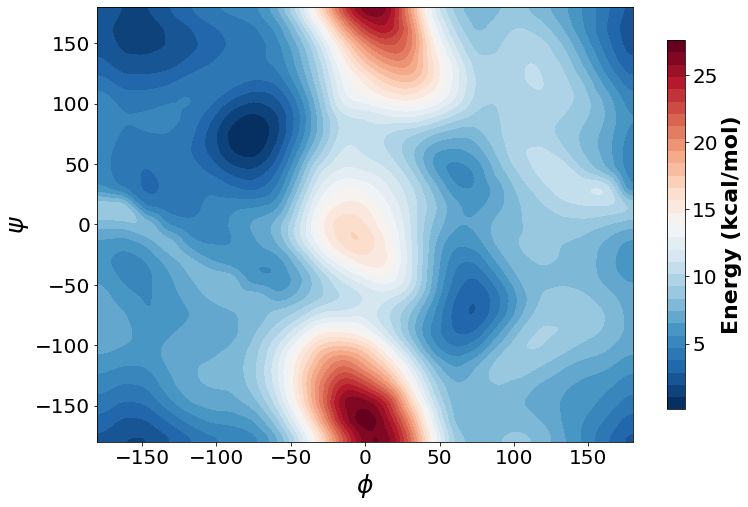

In [ ]:
#@title **Check the reference 2D map calculated with TorchANI**:

#@markdown X-axis and Y-axis are dihedrals angles degrees and Z-axis is energy in kcal/mol.

from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import BSpline
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

with open('ani_plot.dat', 'w') as f:
    for item1, item2, item3 in zip(dihedral_degrees1, dihedral_degrees2, ani_energies):
      degree_str1 = str("{:.0f}".format(item1))
      degree_str2 = str("{:.0f}".format(item2))
      energy_str = str("{:.3f}".format(item3))
      string = degree_str1.rjust(8, " ") + degree_str2.rjust(8, " ") + "      " + energy_str.ljust(8, " ") + " kcal/mol"
      f.write("%s\n" % item3)


dihedral_degrees1 = []
dihedral_degrees2 = []
deg_points = range(-180, (180+int(degrees_steps)), int(degrees_steps))

for i in range(-180, (180+int(degrees_steps)), int(degrees_steps)):
  for deg1, deg2 in zip(np.repeat(i, len(deg_points)), range(-180, (180+int(degrees_steps)), int(degrees_steps))):
    dihedral_degrees1.append(deg1)
    dihedral_degrees2.append(deg2)

data_file = np.loadtxt(os.path.join(workDir, 'ani_plot.dat'))
x = dihedral_degrees1
y = dihedral_degrees2
# z = ani_energies
z = data_file
max_X = np.amax(x)
max_y = np.amax(y)
min_x = np.amin(x)
min_y = np.amin(y)
ycli = np.linspace(max_y, min_y)
xcli = np.linspace(min_x, max_X)
X, Y = np.meshgrid(xcli, ycli)
Z = griddata((x, y), z, (X, Y), method='linear')

plt.figure(figsize=(12, 8))
plt.imshow(Z, extent=[ min_x, max_X, min_y, max_y], cmap=plt.cm.get_cmap('RdBu_r',30), interpolation='bicubic', alpha=1, aspect='auto')

plt.xlabel('$\phi$',  fontsize = 25, fontweight = 'bold')
plt.ylabel('$\psi$', fontsize = 25, fontweight = 'bold')
cbar1 = plt.colorbar(orientation="vertical", shrink=0.85, pad=0.05)
cbar1.ax.tick_params(labelsize=20)
cbar1.set_label('Energy (kcal/mol)',fontsize = 22, fontweight = 'bold')
plt.yticks(size=20)
plt.xticks(size=20)
plt.savefig(os.path.join(workDir, "ani.png"), dpi=600)

In [ ]:
#@title **Download your results (If you are running on Google Colab)**
from google.colab import files
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

if os.path.exists("dihedral_TorchANI2D.zip"):
  os.remove("dihedral_TorchANI2D.zip")
else:
  pass

!zip -FSr "dihedral_TorchANI2D.zip" "mol_files" "pdb_min" *".pdb" *".png" *."txt" *."dat" *."svg"  >/dev/null 2>&1
files.download('dihedral_TorchANI2D.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>